My FinalYear project is going to be based on a trading strategy. I will be using the pair NIKKEI-VIX and from there I will be developing a mean reversion strategy using forecasting methods and a natural language processing model.

First thing I will do is retrive the data and understand it as well as manipulate it.

In [ ]:
#Libraries needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

In [11]:
 Vix = pd.DataFrame(yf.download('^VIX', start = '2023-1-1', end = '2025-3-20', interval = '1d'))
 nikkie = pd.DataFrame(yf.download('NKD=F', start = '2023-1-1', end = '2025-3-20', interval = '1d'))


 #Now I am going to study only the adjusted close, that is the data we are going to use for the model

 VixValues = Vix.Close
 NikkeiValues = nikkie.Close

 print(VixValues.describe())
 print(NikkeiValues.describe())

 #Now I check for any null values inside the data

 print(VixValues.isnull().sum())
 print(NikkeiValues.isnull().sum())

 #After seeing that there are no null values we know that the value the data is complete.
#Lastly we are going to check the shape to check if it matches

 print(VixValues.shape)
 print(NikkeiValues.shape)


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^VIX']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NKD=F']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Ticker  ^VIX
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Ticker  NKD=F
count     0.0
mean      NaN
std       NaN
min       NaN
25%       NaN
50%       NaN
75%       NaN
max       NaN
Ticker
^VIX    0
dtype: int64
Ticker
NKD=F    0
dtype: int64
(0, 1)
(0, 1)


In this step I visualize the data for a better understanding

In [ ]:
#Here I am obteining the returns of the price in a 1 day period over 2 years
#And its volatility over the two years of each month to check for similarities

VixReturns = VixValues / VixValues.shift(1)
VixReturns = VixReturns.dropna()

VixVolatility = VixValues.pct_change().rolling(window = 21).std()
VixVolatility = VixVolatility.dropna()



NikkeiReturns = NikkeiValues / NikkeiValues.shift(1)
NikkeiReturns = NikkeiReturns.dropna()

NikkeiVolatility = NikkeiValues.pct_change().rolling(window = 21).std()
NikkeiVolatility = NikkeiVolatility.dropna()

#Here I will print the values for the returns and volatility as well as checking for null values

print(VixReturns,NikkeiReturns)
print(VixVolatility, NikkeiVolatility)

Empty DataFrame
Columns: [^VIX]
Index: [] Empty DataFrame
Columns: [NKD=F]
Index: []
Empty DataFrame
Columns: [^VIX]
Index: [] Empty DataFrame
Columns: [NKD=F]
Index: []


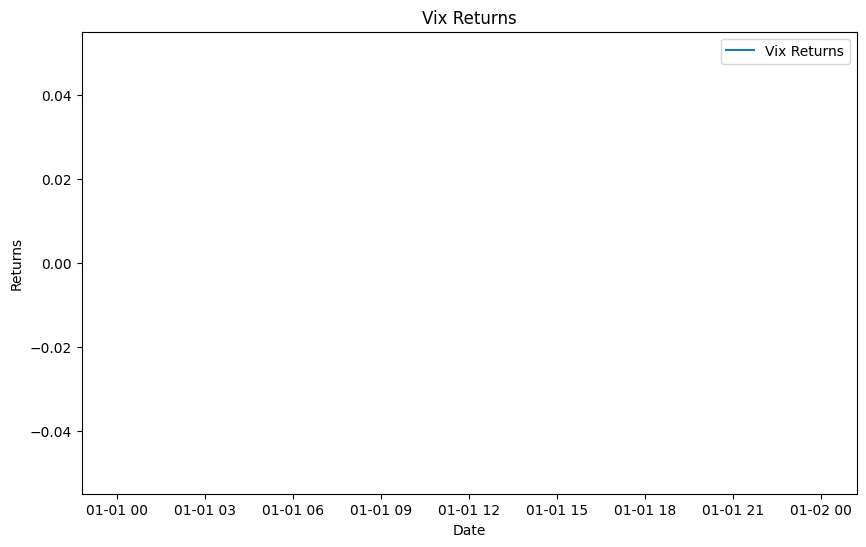

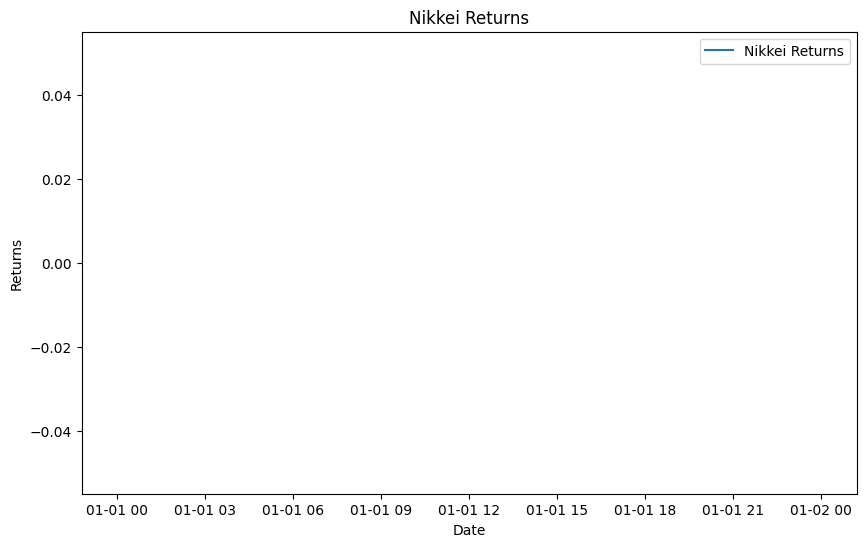

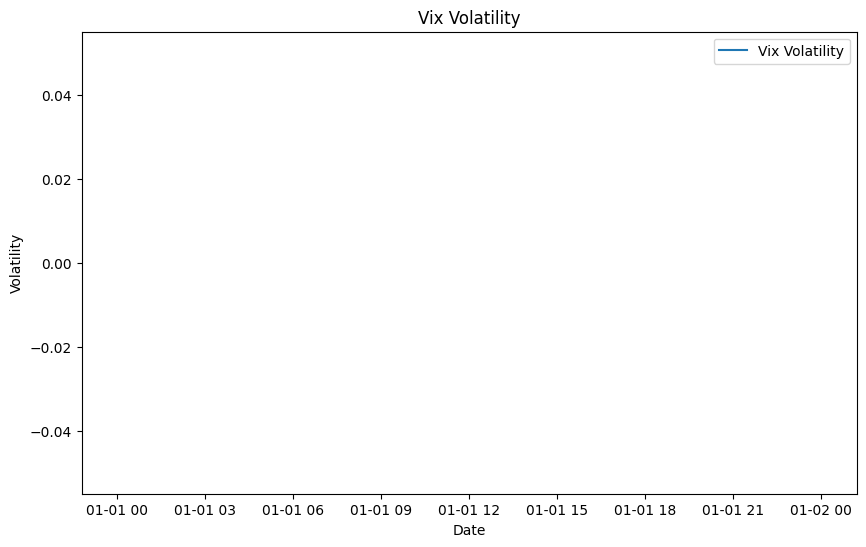

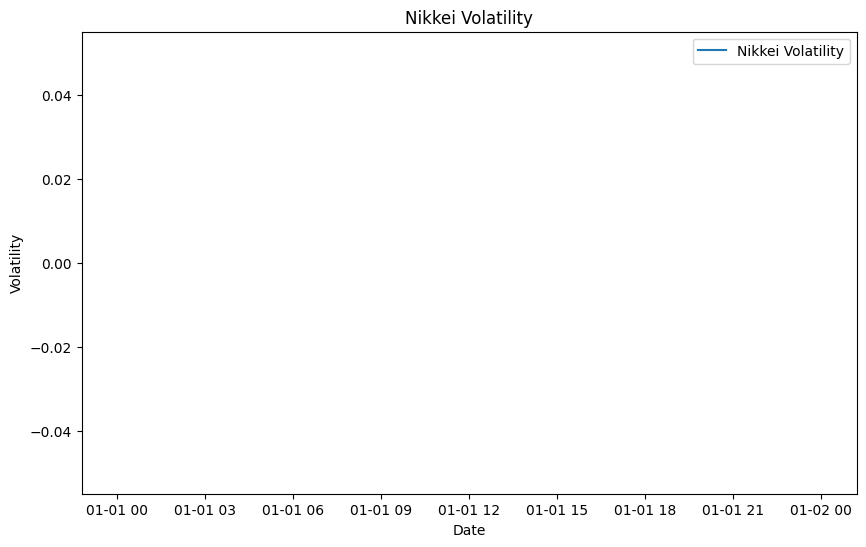

In [ ]:
#After calculating the returns and the volatility I decide to plot it to visualize it.

plt.figure(figsize = (10,6))
plt.plot(VixReturns, label = 'Vix Returns')
plt.title('Vix Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()



plt.figure(figsize = (10,6))
plt.plot(NikkeiReturns, label = 'Nikkei Returns')
plt.title('Nikkei Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()

plt.figure(figsize = (10,6))
plt.plot(VixVolatility, label = 'Vix Volatility')
plt.title('Vix Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()

plt.figure(figsize = (10,6))
plt.plot(NikkeiVolatility, label = 'Nikkei Volatility')
plt.title('Nikkei Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()


plt.show()

After seeing that there are some similiarities in the times where the volume and returns spike, I will check for its corralation and conitegration between both

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


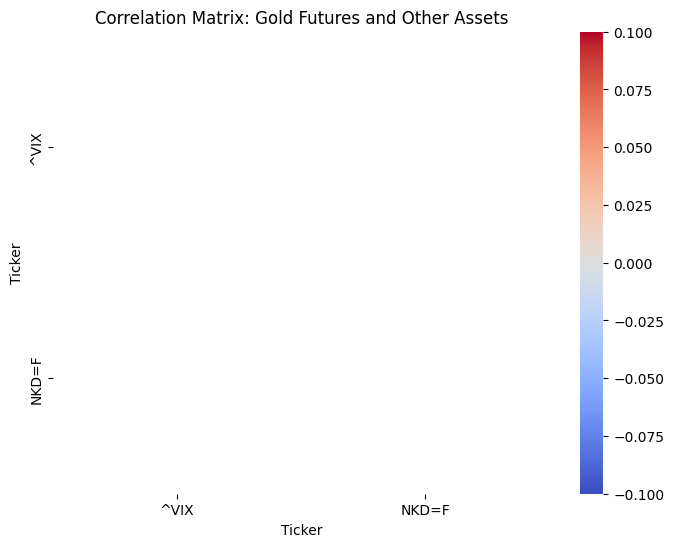

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
#Checking for corralation between both, first I will had the returns to the same dataframe

Returns = pd.DataFrame(VixReturns, index = VixReturns.index)
Returns['NKD=F'] = NikkeiReturns
Returns.head()

#Creating the corralation matrix

corralation_matrix = Returns.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corralation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Gold Futures and Other Assets")
plt.show()

# To check for cointegration we need to do the Engle-Granager test.

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

#Here I perform the test

coint_t,p_value,critical_values = coint(Returns['^VIX'], Returns['NKD=F'])

print(f"Cointegration Test Statistic: {coint_t}")
print(f"P-value: {p_value}")
print(f"Critical Values: {critical_values}")

After runing the corralation and cointegration we can see that they are both corralated and cointegrated at the same time.

 To check for the corralation we just need to see at the matrix, as we can see we get values of -0.56 meaning that they both have a negative corralation

 In terms of the cointegration we need to check for the p_value of the Engle-Granger test. As we can see we fail to reject the null hypothesis and we can say that both have a long-term relationship, meaning they are cointegrated.



The last thing of visualization to do is to plot both of them with their price scaled and see if there are some movements relevant for mean-reversion.

In [ ]:
#This library is the one needed to scale values
!pip install scikit-learn

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


Prices = pd.DataFrame(VixValues, index = VixValues.index)
Prices['NKD=F'] = NikkeiValues

#Here I are scaling the data using a standard scaler
scaled_prices = scaler.fit_transform(Prices)
scaled_prices = pd.DataFrame(scaled_prices, columns = Prices.columns, index = Prices.index)


plt.figure(figsize=(12, 6))
plt.plot(scaled_prices['^VIX'], label='Scaled VIX', color='blue')
plt.plot(scaled_prices['NKD=F'], label='Scaled Nikkei', color='green')
plt.title('Scaled VIX and Nikkei (2023-2025)')
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()




In the plot we can identify some patterns relevant to a mean-reversion strategy. This confirms my deseire to proceed with these pairs.



The next step is retrieving sentimental data, this is the data we are going to use in our natural language processing model where it will give it a score depending on its importance. With this idea we manage to model market sentiment and take it into account for our model.

In [ ]:
#This library is needed for the process
!pip install requests pandas transforms

In [ ]:
#Here I am going to retrive the data from a Free API key.

import requests

API_KEY = "040662afeb88429db4f702eae6a96455" #This key dosnt offer real time data, only from the previous day.
QUERY = "VIX OR United States stock market" # This is tells the api to look for titles containing those key words.
URL = f"https://newsapi.org/v2/everything?q={QUERY}&language=en&sortBy=publishedAt&apiKey={API_KEY}"

#Retrieving the news
response = requests.get(URL)
data = response.json()

#Here I extract the relevant information, create a dataframe and visualize it
articles = data["articles"]
news_data = [{"date": article["publishedAt"], "title": article["title"], "content": article["description"]} for article in articles]


News = pd.DataFrame(news_data)
print(News.tail())


print(News.shape)


As we can see we get data only from the last day,this does limit our model but we can still use this data to understand how our model would work with real time data and backtest it.


Now after retrieving news data and understanding it, we are going to give it a score value. This will then be used in our models. I will achive this by using FinBERT a deep learning model focused in natural language processing.

In [ ]:
# I retrive the function needed
from transformers import pipeline

# I just create the pipeline using FinBert
sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")

#And hgere I append the values of the score and sentiment to the dataframe
News["sentiment"] = News["title"].apply(lambda x: sentiment_pipeline(x)[0]['label'])
News["sentiment_score"] = News["title"].apply(lambda x: sentiment_pipeline(x)[0]['score'])

News

As shown in the data frame abouve, we can identify the two new columns.

Sentiment: Meaning what the sentiment of the news is for the asset, in my case the VIX



Sentimnet score : This value indicates the confidence the model has for its prediction


In [ ]:
#Here I create a visualization to see the distribution of the sentiment values
from matplotlib import pyplot as plt
import seaborn as sns
News.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

The distribution shown is skewed to neutral sentiment. This is something realistic as a lot of the news is not relevant for the VIX

In this stage, after retreaving all the data needed, making sure its aligned and that it has the necessary values. I can begin craeting the mean-reversion algorithm.

For this I decided to shrink the data range, backtesting the model only from 2025-2-5 till 2025-3-20 on an hourly frame. This dates where chosen as the market suffered strong volatilty movements due to US news.

In [ ]:
#Retrieving data from a smaller time frame
#This is done because I dont whant it to take into account events that happened in the past
vixTrade = pd.DataFrame(yf.download('^VIX', start = '2025-2-5', end = '2025-3-20', interval = '1h'))
nikkieTrade = pd.DataFrame(yf.download('NKD=F', start = '2025-2-5', end = '2025-3-20', interval = '1h'))

vixTradeValues = vixTrade.Close
nikkieTradeValues = nikkieTrade.Close

#Scaling the values to create the sequence

TradedValues = pd.DataFrame(vixTradeValues, index = vixTradeValues.index)
TradedValues['NKD=F'] = nikkieTradeValues
TradedValues = TradedValues.dropna()


Scaled_TradedValues = scaler.fit_transform(TradedValues)
Scaled_TradedValues = pd.DataFrame(Scaled_TradedValues, columns = TradedValues.columns, index = TradedValues.index)

print(Scaled_TradedValues.head())


#Now I plot it just to viualize its movement in a shorter timeframe

plt.plot(Scaled_TradedValues['^VIX'], label='Scaled VIX', color='blue')
plt.plot(Scaled_TradedValues['NKD=F'], label='Scaled Nikkei', color='green')
plt.title('Vix and Nikkei (2024-2025,1h)')
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()





Now I will define the spread, for this I need to make sure its a fair value and this is done to make sure that the relationships between the two assets is adjusted. To achived this I used an OLS model.

In [ ]:

import statsmodels.api as sm

#Adding the intercet for the vix and the creation of the OLS

x = sm.add_constant(Scaled_TradedValues['^VIX'])
y= Scaled_TradedValues['NKD=F']

#Now I fit the model

model = sm.OLS(y,x).fit()

#I get the coeficinets

alpha, beta = model.params

model.summary()


#I store the values of the fair value of the nikkei

Scaled_TradedValues['FairValues_NKD=F'] = alpha + beta * Scaled_TradedValues['^VIX']


#Lastly I calculate the fair spread
spread = Scaled_TradedValues['NKD=F'] - Scaled_TradedValues['FairValues_NKD=F']

mean_spread = spread.mean()

plt.plot(spread, label='Spread', color='blue')
plt.title('Spread')
plt.axhline(y=mean_spread, color='pink', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

The plot above shows the spreads movement over the preido of the backtest. You can identify strong mean-reverting behaviours, indicating opportunities for my mean-reverting model.


After calculating the spread I will first check if its stationary,
this is one of the most important topics for mean-reversion strategies

In [ ]:
from statsmodels.tsa.stattools import adfuller

#This is the Adam fuller test, this helps us understand if the data is stationary or not, this is a very key point of the mean-reversion strategy.
adf_test = adfuller(spread)

print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")


After doing the adfuller test we can see that it fails to reject the null hypothesis but due to the risk of differencing and because it only rejects it by a little I will stick with this sread. In cases where the spread is storgly non-stationary differencing needs to be applied to make it stationary but this  eliminates some long-term relationships and adds unnecesary noise, something crucial for my model. Afer this, I am going to define the upper and lower bands for the trading model, these are just the base from where the sentiment analysis will adjust the thresholds.



In [ ]:
#Creating the data base for the spread

df_spread = pd.DataFrame(spread, index = Scaled_TradedValues.index, columns = ['Spread'])
df_spread.index = pd.to_datetime(df_spread.index)
df_spread.set_index(df_spread.index,inplace = True)
print(df_spread.tail())
print(spread.shape)
#Now I am going to define the upper and lower bands of the strategy

upperbound = spread.mean() + 1.5 * spread.std()
lowerbound = spread.mean() - 1.5 * spread.std()

plt.plot(spread, label='Spread', color='blue')
plt.title('Spread')
plt.axhline(y=mean_spread, color='pink', linestyle='--')
plt.axhline(y=upperbound, color='red', linestyle='--')
plt.axhline(y=lowerbound, color='green', linestyle='--')

As we can see in the plot, the spread does actually touch the barriers and then revert to the mean. What we are goign to do know is use the ARIMA model as a confirmation of the reversion of the spread.

 I decided to use an ARMIA model, knowing that the spread is stationary and univariate. I will follow the idea proposed, I will predict the next value of the spread after it touches one of the barriers.

Next step is to create a funcion that we will call when the price of the spread crosses one of the barriers and implement the ARIMA model

In [ ]:
!pip install statsmodels



In [ ]:
from statsmodels.tsa.arima.model import ARIMA



#This function is used to test different parameters of the ARIMA values.


#Here I define the function
def arima_prediction(spread_data):

    model = ARIMA(spread_data, order=(2,0, 2))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    print(model_fit.summary())
    return forecast

print(arima_prediction(spread))


#After comparing different resutls I choose (2,0,2) as the values for the ARIMA model, the results can be seen below

The selection of the parameters 2,0,2 shows promise for its implementation with the spread.

Now I am going to create the trading strategy.


---

Firstly I need to account for the news data only being from a previous day. What I decided to do was to use every news data point as an individual date, matching the data range from the spread. This way each day of the spread I can use a new news article matching that date to dinamically adjust the barriers. This is a solution to the challenge of having a Free API. In real time scenarions, real-time data would be used to adjust the barriers.



In [ ]:

News['date_only'] = pd.to_datetime(News['date']).dt.date

# I add a counter for itraday sequence
News['intraday_seq'] = News.groupby('date_only').cumcount() + 1

# Here I create the artificial dates
start_date = pd.to_datetime("2025-02-05")  # Your backtest start date
News['artificial_date'] = start_date + pd.to_timedelta(News.groupby('date_only').cumcount(), unit='D')
News = News[News['artificial_date'].between(start_date,pd.to_datetime("2025-03-22"))]

#Lastly I create the map
sentiment_map = (
    News.set_index('artificial_date')
    [['sentiment', 'sentiment_score']]
    .to_dict(orient='index')
)

print(pd.DataFrame.from_dict(sentiment_map, orient='index'))


After sucessfully converting the day worth of news data into individual days, I a model the actual trading strategy.

In [ ]:

# I define the function to backtest my algorithm
def backtest_mean_reversion(spread, nikkei, vix, initial_capital=10000, news_data=None):

  # I reset the index to make sure they are all aligned
    spread = spread.reset_index(drop=True)
    nikkei = nikkei.reset_index(drop=True)
    vix = vix.reset_index(drop=True)


    #here I definde the index of the spread and the frequency, in my case hourly
    if not hasattr(spread, 'index') or not isinstance(spread.index, pd.DatetimeIndex):
        spread.index = pd.date_range(start="2025-02-05", periods=len(spread),freq = 'H')
        print(spread.shape)

    # I define the variables to calculate the barriers and the risk taken per trade
    multiplier = 1.5
    risk_per_trade = 0.25
    mean_spread = spread.mean()
    std_spread = spread.std()


    # Now I initialize all the variables used in my algorithm
    trade = None
    entry_price = entry_nikkei = entry_vix = entry_date = None
    capital = available_capital = initial_capital
    trades = []
    barrier_history = []

    upper_bound = None
    lower_b = None
    previous_date = None


    #This is the code used to define the barriers on a daily bases, i iterate over the values of the spread
    # and I calculate the barriers using the sentiment for each day of data

    for i in range(len(spread)):
        current_date = spread.index[i]
        current_spread = spread.iloc[i]
        current_nikkei = nikkei.iloc[i]
        current_vix = vix.iloc[i]

        # I definde the values of the sentiment, and if the day has no news I give it a sentiment score of 0
        if current_date.date() != previous_date:
            sentiment_info = news_data.get(current_date, {'sentiment': 'neutral', 'sentiment_score': 0})
            sentiment_score = sentiment_info['sentiment_score']
            if sentiment_info['sentiment'] == 'negative':
                sentiment_score *= -1
            if sentiment_info['sentiment'] == 'neutral':
                sentiment_score = 0


            # Here I performe the calculation of the barriers
            sentiment_adjustment = 1 - (0.2 * sentiment_score)
            upper_bound = mean_spread + multiplier * std_spread * sentiment_adjustment
            lower_bound = mean_spread - multiplier * std_spread * sentiment_adjustment

            # This line updates the previous date to the current date
            previous_date = current_date.date()


        # Lastly for the barriers I append the values so I can get a better understanding
        barrier_history.append({
            'date': current_date,
            'spread': current_spread,
            'upper': upper_bound,
            'lower': lower_bound,
            'mean': mean_spread,
            'sentiment': sentiment_score
        })


        #THIS IS THE CODE USED FOR THE TRADING MODEL


        # First I define the trading idea for exiting a trade
        if trade in ["Long", "Short"]:
          #This is the condition to exit the trade, if we are in a trade we check for the spread to revert to the mean
            is_exit = (trade == "Long" and current_spread >= mean_spread) or \
                      (trade == "Short" and current_spread <= mean_spread)


            # Here I calculate the return value for the nikkei and the vix after exiting a trade, I also calculate the total captial change
            if is_exit:
                nikkei_return = ((entry_nikkei - current_nikkei) if trade == "Long" else (current_nikkei - entry_nikkei)) / entry_nikkei
                vix_return = ((current_vix - entry_vix) if trade == "Long" else (entry_vix - current_vix)) / entry_vix
                trade_return = (nikkei_return + vix_return) / 2
                capital_change = position_size * trade_return
                capital += capital_change
                available_capital += position_size + capital_change


                # Here I append the values of the trades for further understanding
                trades.append({
                    'type': trade,
                    'entry_date': entry_date,
                    'exit_date': current_date,
                    'entry_spread': entry_price,
                    'exit_spread': current_spread,
                    'nikkei_entry': entry_nikkei,
                    'vix_entry': entry_vix,
                    'nikkei_exit': current_nikkei,
                    'vix_exit': current_vix,
                    'return': trade_return,
                    'capital': capital,
                    'sentiment': sentiment_score,
                    'sentiment info' : sentiment_info['sentiment'],
                    'news': news_data.get(entry_date, {}).get('title', 'No news')
                })

                print(f"\n\u27a1 Exit {trade} on {current_date.date()} | Return: {trade_return*100:.2f}% | Capital: ${capital:.2f}")
                trade = None


        #This is the code used to enter trades based on the spread

        #First I check if the captial is sufficient
        elif available_capital >= initial_capital * risk_per_trade:
            position_size = initial_capital * risk_per_trade
            arima_entry = False

            # I definde the two circunstances where the model can enter a trade
            if current_spread > upper_bound:
                signal = "Short"
                condition = "Predicted < Current"
                expected_move = "mean reversion downward"

            elif current_spread < lower_bound:
                signal = "Long"
                condition = "Predicted > Current"
                expected_move = "mean reversion upward"
            else:
                continue

            try:
              #I define the ARIMA model discussed previously
                model = ARIMA(spread.iloc[:i+1], order=(2, 0, 2))
                model_fit = model.fit()
                predicted = model_fit.forecast()[0]


                #This code is used to confirm the entry of the trade with the ARIMA model if a previous singal was given
                if (signal == "Long" and predicted > current_spread) or (signal == "Short" and predicted < current_spread):
                    trade = signal
                    entry_price = current_spread
                    entry_nikkei = current_nikkei
                    entry_vix = current_vix
                    entry_date = current_date
                    available_capital -= position_size


                    print(f"Opportunity on {current_date.date()} | Forecast: {predicted:.4f} ({condition}) -> Expecting {expected_move} CurrentSpread: {current_spread:.4f} | Sentiment Score: {sentiment_score:.2f} | Sentiment : {sentiment_info['sentiment']} ")
                    print(f"Position: ${position_size:.2f}")

                else:
                    print(f"ARIMA: Waiting for confirmation - {signal} not confirmed")
            except Exception as e:
                print(f"ARIMA Error on {current_date}: {e}")


    # Lastly I calculate the returs of the algorithm as well as the win rate and the average return
    total_return = (capital / initial_capital - 1) * 100
    num_trades = len(trades)
    win_rate = np.mean([t['return'] > 0 for t in trades]) * 100 if trades else 0
    avg_return = np.mean([t['return'] for t in trades]) * 100 if trades else 0
    returns = [t['return'] for t in trades]
    sharpe_ratio = (np.mean(returns) / np.std(returns)) * np.sqrt(252) if len(returns) > 1 and np.std(returns) != 0 else np.nan
    equity_curve = [initial_capital]
    current_capital = initial_capital

    print("\n=== Backtest Summary ===")
    print(f"Initial Capital: ${initial_capital:.2f}")
    print(f"Final Capital: ${capital:.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Trades Executed: {num_trades}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Avg Return/Trade: {avg_return:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")



    # For a better understanding I also plot the entries on the graph of the spread, this allowes me to better understand the algorithm.
    barrier_df = pd.DataFrame(barrier_history).set_index('date')
    plt.figure(figsize=(14, 7))
    plt.plot(barrier_df.index, barrier_df['spread'], label='Spread', color='blue', alpha=0.7)
    plt.plot(barrier_df.index, barrier_df['upper'], '--', label='Upper Barrier', color='red', alpha=0.5)
    plt.plot(barrier_df.index, barrier_df['lower'], '--', label='Lower Barrier', color='green', alpha=0.5)
    plt.axhline(y=mean_spread, color='black', linestyle='-', label='Mean')

    for t in trades:
        #This is to plot the entries of the algorithm
        plt.plot(t['entry_date'], spread.loc[t['entry_date']],
             marker='o', color='green' if t['type'] == 'Long' else 'red')

        plt.plot(t['exit_date'], spread.loc[t['exit_date']],
             marker='o', color='blue')

        #This is for the calculation of the equity curve
        current_capital += t['return'] * initial_capital
        equity_curve.append(current_capital)

        trade_dates = [t['exit_date'] for t in trades]
        trade_dates = [spread.index[0]] + trade_dates  # to start from the beginning

    plt.figure(figsize=(10, 5))
    plt.hist(returns, bins=8, color='skyblue', edgecolor='black')
    plt.title("Histogram of Trade Returns")
    plt.xlabel("Return")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #This is the plot of the Equity curve
    plt.figure(figsize=(12, 6))
    plt.plot(trade_dates, equity_curve, label='Equity Curve', color='purple', linewidth=2)
    plt.title("Equity Curve Over Time")
    plt.xlabel("Date")
    plt.ylabel("Capital ($)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'capital': capital,
        'trades': pd.DataFrame(trades),
        'total_return': total_return,
        'num_trades': num_trades,
        'win_rate': win_rate,
        'avg_return': avg_return,
        'barrier_history': barrier_df
    }


# Calling the funciton with the values I desire, this allows me to also use different assets and different capital allocation to compare.
results = backtest_mean_reversion(
    spread=spread ,
    nikkei=TradedValues['NKD=F'],
    vix=TradedValues['^VIX'],
    initial_capital=10000,
    news_data=sentiment_map
)


Finally we can see the results of the model, We can see that during the backtested period  the model performed quite well, offering a profitable month and a half. There are still some things that need to be look at but this model shows promise for real-world implementations.